# Low-light image enhancement using Retinex-Net

**Description:** Implementing the Retinex-Net architecture for low-light image enhancement.

In [1]:
import os
import time
import random
import argparse
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

# 1 - Data Augmentation

In [2]:
import numpy as np
from PIL import Image

def data_augmentation(image, mode):
    if mode == 0:
        # original
        return image
    elif mode == 1:
        # flip up and down
        return np.flipud(image)
    elif mode == 2:
        # rotate counterwise 90 degree
        return np.rot90(image)
    elif mode == 3:
        # rotate 90 degree and flip up and down
        image = np.rot90(image)
        return np.flipud(image)
    elif mode == 4:
        # rotate 180 degree
        return np.rot90(image, k=2)
    elif mode == 5:
        # rotate 180 degree and flip
        image = np.rot90(image, k=2)
        return np.flipud(image)
    elif mode == 6:
        # rotate 270 degree
        return np.rot90(image, k=3)
    elif mode == 7:
        # rotate 270 degree and flip
        image = np.rot90(image, k=3)
        return np.flipud(image)

# 2 - Load & Save Images

In [3]:
def load_images(file):
    im = Image.open(file)
    return np.array(im, dtype="float32") / 255.0

def save_images(filepath, result_1, result_2 = None):
    result_1 = np.squeeze(result_1)
    result_2 = np.squeeze(result_2)

    if not result_2.any():
        cat_image = result_1
    else:
        cat_image = np.concatenate([result_1, result_2], axis = 1)

    im = Image.fromarray(np.clip(cat_image * 255.0, 0, 255.0).astype('uint8'))
    im.save(filepath, 'png')

# 3 - Model

In [4]:
def concat(layers):
    return tf.concat(layers, axis=3)

def DecomNet(input_im, layer_num, channel=64, kernel_size=3):
    input_max = tf.reduce_max(input_im, axis=3, keepdims=True)
    input_im = concat([input_max, input_im])
    with tf.variable_scope('DecomNet', reuse=tf.AUTO_REUSE):
        conv = tf.layers.conv2d(input_im, channel, kernel_size * 3, padding='same', activation=None, name="shallow_feature_extraction")
        for idx in range(layer_num):
            conv = tf.layers.conv2d(conv, channel, kernel_size, padding='same', activation=tf.nn.relu, name='activated_layer_%d' % idx)
        conv = tf.layers.conv2d(conv, 4, kernel_size, padding='same', activation=None, name='recon_layer')

    R = tf.sigmoid(conv[:,:,:,0:3])
    L = tf.sigmoid(conv[:,:,:,3:4])

    return R, L

def RelightNet(input_L, input_R, channel=64, kernel_size=3):
    input_im = concat([input_R, input_L])
    with tf.variable_scope('RelightNet'):
        conv0 = tf.layers.conv2d(input_im, channel, kernel_size, padding='same', activation=None)
        conv1 = tf.layers.conv2d(conv0, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(conv1, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv3 = tf.layers.conv2d(conv2, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        
        up1 = tf.image.resize_nearest_neighbor(conv3, (tf.shape(conv2)[1], tf.shape(conv2)[2]))
        deconv1 = tf.layers.conv2d(up1, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv2
        up2 = tf.image.resize_nearest_neighbor(deconv1, (tf.shape(conv1)[1], tf.shape(conv1)[2]))
        deconv2= tf.layers.conv2d(up2, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv1
        up3 = tf.image.resize_nearest_neighbor(deconv2, (tf.shape(conv0)[1], tf.shape(conv0)[2]))
        deconv3 = tf.layers.conv2d(up3, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv0
        
        deconv1_resize = tf.image.resize_nearest_neighbor(deconv1, (tf.shape(deconv3)[1], tf.shape(deconv3)[2]))
        deconv2_resize = tf.image.resize_nearest_neighbor(deconv2, (tf.shape(deconv3)[1], tf.shape(deconv3)[2]))
        feature_gather = concat([deconv1_resize, deconv2_resize, deconv3])
        feature_fusion = tf.layers.conv2d(feature_gather, channel, 1, padding='same', activation=None)
        output = tf.layers.conv2d(feature_fusion, 1, 3, padding='same', activation=None)
    return output

class lowlight_enhance(object):
    def __init__(self, sess):
        self.sess = sess
        self.DecomNet_layer_num = 5

        # build the model
        self.input_low = tf.placeholder(tf.float32, [None, None, None, 3], name='input_low')
        self.input_high = tf.placeholder(tf.float32, [None, None, None, 3], name='input_high')

        [R_low, I_low] = DecomNet(self.input_low, layer_num=self.DecomNet_layer_num)
        [R_high, I_high] = DecomNet(self.input_high, layer_num=self.DecomNet_layer_num)
        
        I_delta = RelightNet(I_low, R_low)

        I_low_3 = concat([I_low, I_low, I_low])
        I_high_3 = concat([I_high, I_high, I_high])
        I_delta_3 = concat([I_delta, I_delta, I_delta])

        self.output_R_low = R_low
        self.output_I_low = I_low_3
        self.output_I_delta = I_delta_3
        self.output_S = R_low * I_delta_3

        # loss
        self.recon_loss_low = tf.reduce_mean(tf.abs(R_low * I_low_3 -  self.input_low))
        self.recon_loss_high = tf.reduce_mean(tf.abs(R_high * I_high_3 - self.input_high))
        self.recon_loss_mutal_low = tf.reduce_mean(tf.abs(R_high * I_low_3 - self.input_low))
        self.recon_loss_mutal_high = tf.reduce_mean(tf.abs(R_low * I_high_3 - self.input_high))
        self.equal_R_loss = tf.reduce_mean(tf.abs(R_low - R_high))
        self.relight_loss = tf.reduce_mean(tf.abs(R_low * I_delta_3 - self.input_high))

        self.Ismooth_loss_low = self.smooth(I_low, R_low)
        self.Ismooth_loss_high = self.smooth(I_high, R_high)
        self.Ismooth_loss_delta = self.smooth(I_delta, R_low)

        self.loss_Decom = self.recon_loss_low + self.recon_loss_high + 0.001 * self.recon_loss_mutal_low + 0.001 * self.recon_loss_mutal_high + 0.1 * self.Ismooth_loss_low + 0.1 * self.Ismooth_loss_high + 0.01 * self.equal_R_loss
        self.loss_Relight = self.relight_loss + 3 * self.Ismooth_loss_delta

        self.lr = tf.placeholder(tf.float32, name='learning_rate')
        optimizer = tf.train.AdamOptimizer(self.lr, name='AdamOptimizer')

        self.var_Decom = [var for var in tf.trainable_variables() if 'DecomNet' in var.name]
        self.var_Relight = [var for var in tf.trainable_variables() if 'RelightNet' in var.name]

        self.train_op_Decom = optimizer.minimize(self.loss_Decom, var_list = self.var_Decom)
        self.train_op_Relight = optimizer.minimize(self.loss_Relight, var_list = self.var_Relight)

        self.sess.run(tf.global_variables_initializer())

        self.saver_Decom = tf.train.Saver(var_list = self.var_Decom)
        self.saver_Relight = tf.train.Saver(var_list = self.var_Relight)

        print("[*] Initialize model successfully...")

    def gradient(self, input_tensor, direction):
        self.smooth_kernel_x = tf.reshape(tf.constant([[0, 0], [-1, 1]], tf.float32), [2, 2, 1, 1])
        self.smooth_kernel_y = tf.transpose(self.smooth_kernel_x, [1, 0, 2, 3])

        if direction == "x":
            kernel = self.smooth_kernel_x
        elif direction == "y":
            kernel = self.smooth_kernel_y
        return tf.abs(tf.nn.conv2d(input_tensor, kernel, strides=[1, 1, 1, 1], padding='SAME'))

    def ave_gradient(self, input_tensor, direction):
        return tf.layers.average_pooling2d(self.gradient(input_tensor, direction), pool_size=3, strides=1, padding='SAME')

    def smooth(self, input_I, input_R):
        input_R = tf.image.rgb_to_grayscale(input_R)
        return tf.reduce_mean(self.gradient(input_I, "x") * tf.exp(-10 * self.ave_gradient(input_R, "x")) + self.gradient(input_I, "y") * tf.exp(-10 * self.ave_gradient(input_R, "y")))

    def evaluate(self, epoch_num, eval_low_data, sample_dir, train_phase):
        print("[*] Evaluating for phase %s / epoch %d..." % (train_phase, epoch_num))

        for idx in range(len(eval_low_data)):
            input_low_eval = np.expand_dims(eval_low_data[idx], axis=0)

            if train_phase == "Decom":
                result_1, result_2 = self.sess.run([self.output_R_low, self.output_I_low], feed_dict={self.input_low: input_low_eval})
            if train_phase == "Relight":
                result_1, result_2 = self.sess.run([self.output_S, self.output_I_delta], feed_dict={self.input_low: input_low_eval})

            save_images(os.path.join(sample_dir, 'eval_%s_%d_%d.png' % (train_phase, idx + 1, epoch_num)), result_1, result_2)
        
    def train(self, train_low_data, train_high_data, eval_low_data, batch_size, patch_size, epoch, lr, sample_dir, ckpt_dir, eval_every_epoch, train_phase):
        assert len(train_low_data) == len(train_high_data)
        numBatch = len(train_low_data) // int(batch_size)

        # load pretrained model
        if train_phase == "Decom":
            train_op = self.train_op_Decom
            train_loss = self.loss_Decom
            saver = self.saver_Decom
        elif train_phase == "Relight":
            train_op = self.train_op_Relight
            train_loss = self.loss_Relight
            saver = self.saver_Relight

        load_model_status, global_step = self.load(saver, ckpt_dir)
        if load_model_status:
            iter_num = global_step
            start_epoch = global_step // numBatch
            start_step = global_step % numBatch
            print("[*] Model restore success!")
        else:
            iter_num = 0
            start_epoch = 0
            start_step = 0
            print("[*] Not find pretrained model!")

        print("[*] Start training for phase %s, with start epoch %d start iter %d : " % (train_phase, start_epoch, iter_num))

        start_time = time.time()
        image_id = 0
        
        ###############################################################
        # Initialize lists to store loss values and epochs
        loss_epochs = []
        epoch_nums = []
        ###############################################################
        
        for epoch in range(start_epoch, epoch):
            for batch_id in range(start_step, numBatch):
                # generate data for a batch
                batch_input_low = np.zeros((batch_size, patch_size, patch_size, 3), dtype="float32")
                batch_input_high = np.zeros((batch_size, patch_size, patch_size, 3), dtype="float32")
                for patch_id in range(batch_size):
                    h, w, _ = train_low_data[image_id].shape
                    x = random.randint(0, h - patch_size)
                    y = random.randint(0, w - patch_size)
            
                    rand_mode = random.randint(0, 7)
                    batch_input_low[patch_id, :, :, :] = data_augmentation(train_low_data[image_id][x : x+patch_size, y : y+patch_size, :], rand_mode)
                    batch_input_high[patch_id, :, :, :] = data_augmentation(train_high_data[image_id][x : x+patch_size, y : y+patch_size, :], rand_mode)
                    
                    image_id = (image_id + 1) % len(train_low_data)
                    if image_id == 0:
                        tmp = list(zip(train_low_data, train_high_data))
                        random.shuffle(list(tmp))
                        train_low_data, train_high_data  = zip(*tmp)

                # train
                _, loss = self.sess.run([train_op, train_loss], feed_dict={self.input_low: batch_input_low, \
                                                                           self.input_high: batch_input_high, \
                                                                           self.lr: lr[epoch]})
                
                print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f" \
                      % (train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
                iter_num += 1
            
            
            # evalutate the model and save a checkpoint file for it
            if (epoch + 1) % eval_every_epoch == 0:
                self.evaluate(epoch + 1, eval_low_data, sample_dir=sample_dir, train_phase=train_phase)
                self.save(saver, iter_num, ckpt_dir, "RetinexNet-%s" % train_phase)

            ###############################################################
            # Append loss and epoch number
            loss_epochs.append(loss)
            epoch_nums.append(epoch + 1)
            ###############################################################
                
        ###############################################################
        if (train_phase == 'Decom'):
            # Plot and save the loss graph
            plt.plot(epoch_nums, loss_epochs)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss Over Epochs (DecomNet)')
            plt.savefig(os.path.join(sample_dir, 'loss_graph_Decom.png'))
            plt.show()
        else:
            # Plot and save the loss graph
            plt.plot(epoch_nums, loss_epochs)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss Over Epochs (Relight)')
            plt.savefig(os.path.join(sample_dir, 'loss_graph_Relight.png'))
            plt.show()
        ###############################################################
        
        print("[*] Finish training for phase %s." % train_phase)

    def save(self, saver, iter_num, ckpt_dir, model_name):
        if not os.path.exists(ckpt_dir):
            os.makedirs(ckpt_dir)
        print("[*] Saving model %s" % model_name)
        saver.save(self.sess, \
                   os.path.join(ckpt_dir, model_name), \
                   global_step=iter_num)

    def load(self, saver, ckpt_dir):
        ckpt = tf.train.get_checkpoint_state(ckpt_dir)
        if ckpt and ckpt.model_checkpoint_path:
            full_path = tf.train.latest_checkpoint(ckpt_dir)
            try:
                global_step = int(full_path.split('/')[-1].split('-')[-1])
            except ValueError:
                global_step = None
            saver.restore(self.sess, full_path)
            return True, global_step
        else:
            print("[*] Failed to load model from %s" % ckpt_dir)
            return False, 0

    def test(self, test_low_data, test_high_data, test_low_data_names, save_dir, decom_flag):
        tf.global_variables_initializer().run()

        print("[*] Reading checkpoint...")
        load_model_status_Decom, _ = self.load(self.saver_Decom, './model/Decom')
        load_model_status_Relight, _ = self.load(self.saver_Relight, './model/Relight')
        if load_model_status_Decom and load_model_status_Relight:
            print("[*] Load weights successfully...")
        
        print("[*] Testing...")
        for idx in range(len(test_low_data)):
            print(test_low_data_names[idx])
            [_, name] = os.path.split(test_low_data_names[idx])
            suffix = name[name.find('.') + 1:]
            name = name[:name.find('.')]

            input_low_test = np.expand_dims(test_low_data[idx], axis=0)         

            [R_low, I_low, I_delta, S] = self.sess.run([self.output_R_low, self.output_I_low, self.output_I_delta, self.output_S], feed_dict = {self.input_low: input_low_test})

            if decom_flag == 1:
                save_images(os.path.join(save_dir, name + "_R_low." + suffix), R_low)
                save_images(os.path.join(save_dir, name + "_I_low." + suffix), I_low)
                save_images(os.path.join(save_dir, name + "_I_delta." + suffix), I_delta)
            save_images(os.path.join(save_dir, name + "_S."   + suffix), S)

# 4 - Training

In [5]:
def lowlight_train(lowlight_enhance):
    if not os.path.exists(args.ckpt_dir):
        os.makedirs(args.ckpt_dir)
    if not os.path.exists(args.sample_dir):
        os.makedirs(args.sample_dir)

    lr = args.start_lr * np.ones([args.epoch])
    lr[20:] = lr[0] / 10.0

    train_low_data = []
    train_high_data = []

    train_low_data_names = glob('./data/our485/low/*.png') + glob('./data/syn/low/*.png')
    train_low_data_names.sort()
    train_high_data_names = glob('./data/our485/high/*.png') + glob('./data/syn/high/*.png')
    train_high_data_names.sort()
    assert len(train_low_data_names) == len(train_high_data_names)
    print('[*] Number of training data: %d' % len(train_low_data_names))

    for idx in range(len(train_low_data_names)):
        low_im = load_images(train_low_data_names[idx])
        train_low_data.append(low_im)
        high_im = load_images(train_high_data_names[idx])
        train_high_data.append(high_im)

    eval_low_data = []
    eval_high_data = []

    eval_low_data_name = glob('./data/eval/low/*.*')

    for idx in range(len(eval_low_data_name)):
        eval_low_im = load_images(eval_low_data_name[idx])
        eval_low_data.append(eval_low_im)

    lowlight_enhance.train(train_low_data, train_high_data, eval_low_data, batch_size=args.batch_size, patch_size=args.patch_size, epoch=args.epoch, lr=lr, sample_dir=args.sample_dir, ckpt_dir=os.path.join(args.ckpt_dir, 'Decom'), eval_every_epoch=args.eval_every_epoch, train_phase="Decom")

    lowlight_enhance.train(train_low_data, train_high_data, eval_low_data, batch_size=args.batch_size, patch_size=args.patch_size, epoch=args.epoch, lr=lr, sample_dir=args.sample_dir, ckpt_dir=os.path.join(args.ckpt_dir, 'Relight'), eval_every_epoch=args.eval_every_epoch, train_phase="Relight")

# 5 - Testing

In [6]:
def lowlight_test(lowlight_enhance):
    if args.test_dir == None:
        print("[!] please provide --test_dir")
        exit(0)

    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    test_low_data_name = glob(os.path.join(args.test_dir) + '/*.*')
    test_low_data = []
    test_high_data = []
    for idx in range(len(test_low_data_name)):
        test_low_im = load_images(test_low_data_name[idx])
        test_low_data.append(test_low_im)

    lowlight_enhance.test(test_low_data, test_high_data, test_low_data_name, save_dir=args.save_dir, decom_flag=args.decom)

# 6 - Main function with arguments configuration

In [7]:
parser = argparse.ArgumentParser(description='')

parser.add_argument('--use_gpu', dest='use_gpu', type=int, default=1, help='gpu flag, 1 for GPU and 0 for CPU')
parser.add_argument('--gpu_idx', dest='gpu_idx', default="0", help='GPU idx')
parser.add_argument('--gpu_mem', dest='gpu_mem', type=float, default=0.5, help="0 to 1, gpu memory usage")
parser.add_argument('--phase', dest='phase', default='train', help='train or test')

parser.add_argument('--epoch', dest='epoch', type=int, default=100, help='number of total epoches')
parser.add_argument('--batch_size', dest='batch_size', type=int, default=16, help='number of samples in one batch')
parser.add_argument('--patch_size', dest='patch_size', type=int, default=48, help='patch size')
parser.add_argument('--start_lr', dest='start_lr', type=float, default=0.001, help='initial learning rate for adam')
parser.add_argument('--eval_every_epoch', dest='eval_every_epoch', default=20, help='evaluating and saving checkpoints every #  epoch')
parser.add_argument('--ckpt_dir', dest='ckpt_dir', default='./checkpoint', help='directory for checkpoints')
parser.add_argument('--sample_dir', dest='sample_dir', default='./sample', help='directory for evaluating outputs')

parser.add_argument('--save_dir', dest='save_dir', default='./test_results', help='directory for testing outputs')
parser.add_argument('--test_dir', dest='test_dir', default='./data/test/low', help='directory for testing inputs')
parser.add_argument('--decom', dest='decom', default=0, help='decom flag, 0 for enhanced results only and 1 for decomposition results')

args, unknown = parser.parse_known_args()


def main(args):
    if args.use_gpu:
        print("[*] GPU\n")
        os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_idx
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=args.gpu_mem)
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
            model = lowlight_enhance(sess)
            if args.phase == 'train':
                lowlight_train(model)
            elif args.phase == 'test':
                lowlight_test(model)
            else:
                print('[!] Unknown phase')
                exit(0)
    else:
        print("[*] CPU\n")
        with tf.Session() as sess:
            model = lowlight_enhance(sess)
            if args.phase == 'train':
                lowlight_train(model)
            elif args.phase == 'test':
                lowlight_test(model)
            else:
                print('[!] Unknown phase')
                exit(0)

# 7 - Call the main function with the provided arguments

## 7.1 - Training the model

### Arguments detail for training
    --use_gpu=1 \                           # use gpu or not
    --gpu_idx=0 \
    --gpu_mem=0.5 \                         # gpu memory usage
    --phase=train \
    --epoch=100 \                           # number of training epoches
    --batch_size=16 \
    --patch_size=48 \                       # size of training patches
    --start_lr=0.001 \                      # initial learning rate for adm
    --eval_every_epoch=20 \                 # evaluate and save checkpoints for every # epoches
    --checkpoint_dir=./checkpoint           # if it is not existed, automatically make dirs
    --sample_dir=./sample                   # dir for saving evaluation results during training

In [8]:
args = argparse.Namespace(use_gpu=1, gpu_idx='0', gpu_mem=0.5, phase='train', epoch=100, batch_size=16, patch_size=48, start_lr=0.001, eval_every_epoch=20, ckpt_dir='./checkpoint', sample_dir='./sample')

[*] GPU

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
[*] Initialize model successfully...
[*] Number of training data: 500
[*] Failed to load model from ./checkpoint\Decom
[*] Not find pretrained model!
[*] Start training for phase Decom, with start epoch 0 start iter 0 : 
Decom Epoch: [ 1] [   1/  31] time: 0.4820, loss: 0.481529
Decom Epoch: [ 1] [   2/  31] time: 0.7635, loss: 0.382665
Decom Epoch: [ 1] [   3/  31] time: 1.0840, loss: 0.541997
Decom Epoch: [ 1] [   4/  31] time: 1.3814, loss: 0.406680
Decom Epoch: [ 1] [   5/  31] time: 1.6816, loss: 0.346366
Decom Epoch: [ 1] [   6/  31] time: 1.9764, loss: 0.441551
Decom Epoch: [ 1] [   7/  31] time: 2.2732, loss: 0.360328
Decom Epoch: [ 1] [   8/  31] time: 2.5720, loss: 0.342579
Decom Epoch: [ 1] [   9/  31] time: 2.8937, loss: 0.346017
Decom Epoch: [ 1] [  10/  31] tim

Decom Epoch: [ 4] [  29/  31] time: 36.9522, loss: 0.075828
Decom Epoch: [ 4] [  30/  31] time: 37.2350, loss: 0.067582
Decom Epoch: [ 4] [  31/  31] time: 37.5448, loss: 0.071699
Decom Epoch: [ 5] [   1/  31] time: 37.8396, loss: 0.095992
Decom Epoch: [ 5] [   2/  31] time: 38.1334, loss: 0.062569
Decom Epoch: [ 5] [   3/  31] time: 38.4182, loss: 0.084145
Decom Epoch: [ 5] [   4/  31] time: 38.7400, loss: 0.076881
Decom Epoch: [ 5] [   5/  31] time: 39.0338, loss: 0.059290
Decom Epoch: [ 5] [   6/  31] time: 39.3375, loss: 0.052630
Decom Epoch: [ 5] [   7/  31] time: 39.6313, loss: 0.076381
Decom Epoch: [ 5] [   8/  31] time: 39.9521, loss: 0.082975
Decom Epoch: [ 5] [   9/  31] time: 40.2469, loss: 0.043889
Decom Epoch: [ 5] [  10/  31] time: 40.5387, loss: 0.062558
Decom Epoch: [ 5] [  11/  31] time: 40.8474, loss: 0.085237
Decom Epoch: [ 5] [  12/  31] time: 41.1412, loss: 0.089571
Decom Epoch: [ 5] [  13/  31] time: 41.4290, loss: 0.097544
Decom Epoch: [ 5] [  14/  31] time: 41.7

Decom Epoch: [ 9] [  11/  31] time: 78.9070, loss: 0.054604
Decom Epoch: [ 9] [  12/  31] time: 79.2017, loss: 0.068888
Decom Epoch: [ 9] [  13/  31] time: 79.4995, loss: 0.056049
Decom Epoch: [ 9] [  14/  31] time: 79.7873, loss: 0.075082
Decom Epoch: [ 9] [  15/  31] time: 80.0791, loss: 0.061262
Decom Epoch: [ 9] [  16/  31] time: 80.4058, loss: 0.075768
Decom Epoch: [ 9] [  17/  31] time: 80.7290, loss: 0.054124
Decom Epoch: [ 9] [  18/  31] time: 81.0238, loss: 0.041247
Decom Epoch: [ 9] [  19/  31] time: 81.3191, loss: 0.061833
Decom Epoch: [ 9] [  20/  31] time: 81.6513, loss: 0.054294
Decom Epoch: [ 9] [  21/  31] time: 81.9511, loss: 0.065752
Decom Epoch: [ 9] [  22/  31] time: 82.2469, loss: 0.053286
Decom Epoch: [ 9] [  23/  31] time: 82.5686, loss: 0.062156
Decom Epoch: [ 9] [  24/  31] time: 82.8674, loss: 0.073442
Decom Epoch: [ 9] [  25/  31] time: 83.1592, loss: 0.094722
Decom Epoch: [ 9] [  26/  31] time: 83.4769, loss: 0.051404
Decom Epoch: [ 9] [  27/  31] time: 83.7

Decom Epoch: [13] [  23/  31] time: 120.0640, loss: 0.057647
Decom Epoch: [13] [  24/  31] time: 120.3807, loss: 0.060158
Decom Epoch: [13] [  25/  31] time: 120.6785, loss: 0.047264
Decom Epoch: [13] [  26/  31] time: 120.9713, loss: 0.057842
Decom Epoch: [13] [  27/  31] time: 121.2880, loss: 0.045597
Decom Epoch: [13] [  28/  31] time: 121.5838, loss: 0.047668
Decom Epoch: [13] [  29/  31] time: 121.8756, loss: 0.063021
Decom Epoch: [13] [  30/  31] time: 122.1863, loss: 0.041664
Decom Epoch: [13] [  31/  31] time: 122.4731, loss: 0.043837
Decom Epoch: [14] [   1/  31] time: 122.7799, loss: 0.056851
Decom Epoch: [14] [   2/  31] time: 123.0747, loss: 0.041897
Decom Epoch: [14] [   3/  31] time: 123.3655, loss: 0.058665
Decom Epoch: [14] [   4/  31] time: 123.6822, loss: 0.048567
Decom Epoch: [14] [   5/  31] time: 123.9810, loss: 0.042692
Decom Epoch: [14] [   6/  31] time: 124.2827, loss: 0.053704
Decom Epoch: [14] [   7/  31] time: 124.5855, loss: 0.040767
Decom Epoch: [14] [   8/

Decom Epoch: [18] [   3/  31] time: 161.8220, loss: 0.033692
Decom Epoch: [18] [   4/  31] time: 162.1412, loss: 0.045680
Decom Epoch: [18] [   5/  31] time: 162.4570, loss: 0.048654
Decom Epoch: [18] [   6/  31] time: 162.7757, loss: 0.041191
Decom Epoch: [18] [   7/  31] time: 163.0984, loss: 0.037135
Decom Epoch: [18] [   8/  31] time: 163.4171, loss: 0.041134
Decom Epoch: [18] [   9/  31] time: 163.7354, loss: 0.039291
Decom Epoch: [18] [  10/  31] time: 164.0481, loss: 0.035990
Decom Epoch: [18] [  11/  31] time: 164.3659, loss: 0.040521
Decom Epoch: [18] [  12/  31] time: 164.6846, loss: 0.045742
Decom Epoch: [18] [  13/  31] time: 165.0003, loss: 0.044030
Decom Epoch: [18] [  14/  31] time: 165.3181, loss: 0.049501
Decom Epoch: [18] [  15/  31] time: 165.6413, loss: 0.039178
Decom Epoch: [18] [  16/  31] time: 165.9550, loss: 0.049134
Decom Epoch: [18] [  17/  31] time: 166.2698, loss: 0.057431
Decom Epoch: [18] [  18/  31] time: 166.5955, loss: 0.043357
Decom Epoch: [18] [  19/

Decom Epoch: [22] [  13/  31] time: 204.5991, loss: 0.031986
Decom Epoch: [22] [  14/  31] time: 204.9218, loss: 0.034172
Decom Epoch: [22] [  15/  31] time: 205.2530, loss: 0.049841
Decom Epoch: [22] [  16/  31] time: 205.5747, loss: 0.036456
Decom Epoch: [22] [  17/  31] time: 205.9044, loss: 0.044502
Decom Epoch: [22] [  18/  31] time: 206.2476, loss: 0.063198
Decom Epoch: [22] [  19/  31] time: 206.5893, loss: 0.056079
Decom Epoch: [22] [  20/  31] time: 206.9140, loss: 0.037117
Decom Epoch: [22] [  21/  31] time: 207.2472, loss: 0.027676
Decom Epoch: [22] [  22/  31] time: 207.5689, loss: 0.041015
Decom Epoch: [22] [  23/  31] time: 207.8887, loss: 0.025106
Decom Epoch: [22] [  24/  31] time: 208.2005, loss: 0.035419
Decom Epoch: [22] [  25/  31] time: 208.5122, loss: 0.035252
Decom Epoch: [22] [  26/  31] time: 208.8309, loss: 0.036783
Decom Epoch: [22] [  27/  31] time: 209.1486, loss: 0.043818
Decom Epoch: [22] [  28/  31] time: 209.4609, loss: 0.051710
Decom Epoch: [22] [  29/

Decom Epoch: [26] [  24/  31] time: 246.9466, loss: 0.031475
Decom Epoch: [26] [  25/  31] time: 247.2683, loss: 0.028444
Decom Epoch: [26] [  26/  31] time: 247.5990, loss: 0.028468
Decom Epoch: [26] [  27/  31] time: 247.9337, loss: 0.031195
Decom Epoch: [26] [  28/  31] time: 248.2484, loss: 0.036570
Decom Epoch: [26] [  29/  31] time: 248.5766, loss: 0.052873
Decom Epoch: [26] [  30/  31] time: 248.8953, loss: 0.034067
Decom Epoch: [26] [  31/  31] time: 249.2190, loss: 0.032041
Decom Epoch: [27] [   1/  31] time: 249.5388, loss: 0.044197
Decom Epoch: [27] [   2/  31] time: 249.8495, loss: 0.031508
Decom Epoch: [27] [   3/  31] time: 250.1727, loss: 0.031918
Decom Epoch: [27] [   4/  31] time: 250.5054, loss: 0.039373
Decom Epoch: [27] [   5/  31] time: 250.8451, loss: 0.032239
Decom Epoch: [27] [   6/  31] time: 251.1549, loss: 0.036168
Decom Epoch: [27] [   7/  31] time: 251.4642, loss: 0.037397
Decom Epoch: [27] [   8/  31] time: 251.7689, loss: 0.028650
Decom Epoch: [27] [   9/

Decom Epoch: [31] [   4/  31] time: 288.8802, loss: 0.035349
Decom Epoch: [31] [   5/  31] time: 289.1840, loss: 0.035809
Decom Epoch: [31] [   6/  31] time: 289.4888, loss: 0.028455
Decom Epoch: [31] [   7/  31] time: 289.7945, loss: 0.037833
Decom Epoch: [31] [   8/  31] time: 290.1013, loss: 0.029558
Decom Epoch: [31] [   9/  31] time: 290.4020, loss: 0.032017
Decom Epoch: [31] [  10/  31] time: 290.7098, loss: 0.028708
Decom Epoch: [31] [  11/  31] time: 291.0175, loss: 0.021247
Decom Epoch: [31] [  12/  31] time: 291.3193, loss: 0.025869
Decom Epoch: [31] [  13/  31] time: 291.6300, loss: 0.031111
Decom Epoch: [31] [  14/  31] time: 291.9268, loss: 0.030593
Decom Epoch: [31] [  15/  31] time: 292.2286, loss: 0.031832
Decom Epoch: [31] [  16/  31] time: 292.5363, loss: 0.021857
Decom Epoch: [31] [  17/  31] time: 292.8351, loss: 0.033871
Decom Epoch: [31] [  18/  31] time: 293.1448, loss: 0.040927
Decom Epoch: [31] [  19/  31] time: 293.4456, loss: 0.038461
Decom Epoch: [31] [  20/

Decom Epoch: [35] [  15/  31] time: 330.2169, loss: 0.036998
Decom Epoch: [35] [  16/  31] time: 330.5207, loss: 0.025611
Decom Epoch: [35] [  17/  31] time: 330.8194, loss: 0.024948
Decom Epoch: [35] [  18/  31] time: 331.1222, loss: 0.028493
Decom Epoch: [35] [  19/  31] time: 331.4310, loss: 0.038243
Decom Epoch: [35] [  20/  31] time: 331.7417, loss: 0.034229
Decom Epoch: [35] [  21/  31] time: 332.0505, loss: 0.043544
Decom Epoch: [35] [  22/  31] time: 332.3592, loss: 0.044642
Decom Epoch: [35] [  23/  31] time: 332.6735, loss: 0.034470
Decom Epoch: [35] [  24/  31] time: 332.9992, loss: 0.025097
Decom Epoch: [35] [  25/  31] time: 333.3169, loss: 0.039912
Decom Epoch: [35] [  26/  31] time: 333.6157, loss: 0.026419
Decom Epoch: [35] [  27/  31] time: 333.9394, loss: 0.031876
Decom Epoch: [35] [  28/  31] time: 334.2501, loss: 0.031217
Decom Epoch: [35] [  29/  31] time: 334.5678, loss: 0.035906
Decom Epoch: [35] [  30/  31] time: 334.8781, loss: 0.041851
Decom Epoch: [35] [  31/

Decom Epoch: [39] [  26/  31] time: 371.5327, loss: 0.035487
Decom Epoch: [39] [  27/  31] time: 371.8355, loss: 0.026009
Decom Epoch: [39] [  28/  31] time: 372.1512, loss: 0.020904
Decom Epoch: [39] [  29/  31] time: 372.4520, loss: 0.035476
Decom Epoch: [39] [  30/  31] time: 372.7518, loss: 0.031527
Decom Epoch: [39] [  31/  31] time: 373.0625, loss: 0.049190
Decom Epoch: [40] [   1/  31] time: 373.3758, loss: 0.044246
Decom Epoch: [40] [   2/  31] time: 373.6835, loss: 0.040989
Decom Epoch: [40] [   3/  31] time: 373.9843, loss: 0.030028
Decom Epoch: [40] [   4/  31] time: 374.2851, loss: 0.032189
Decom Epoch: [40] [   5/  31] time: 374.5888, loss: 0.031992
Decom Epoch: [40] [   6/  31] time: 374.8956, loss: 0.034477
Decom Epoch: [40] [   7/  31] time: 375.1984, loss: 0.037695
Decom Epoch: [40] [   8/  31] time: 375.5111, loss: 0.033301
Decom Epoch: [40] [   9/  31] time: 375.7919, loss: 0.034871
Decom Epoch: [40] [  10/  31] time: 376.0967, loss: 0.031421
Decom Epoch: [40] [  11/

Decom Epoch: [44] [   5/  31] time: 412.4624, loss: 0.043659
Decom Epoch: [44] [   6/  31] time: 412.7766, loss: 0.035444
Decom Epoch: [44] [   7/  31] time: 413.1053, loss: 0.030313
Decom Epoch: [44] [   8/  31] time: 413.4041, loss: 0.036727
Decom Epoch: [44] [   9/  31] time: 413.7009, loss: 0.028788
Decom Epoch: [44] [  10/  31] time: 414.0076, loss: 0.029212
Decom Epoch: [44] [  11/  31] time: 414.3284, loss: 0.032118
Decom Epoch: [44] [  12/  31] time: 414.6611, loss: 0.027588
Decom Epoch: [44] [  13/  31] time: 414.9678, loss: 0.028131
Decom Epoch: [44] [  14/  31] time: 415.2696, loss: 0.034157
Decom Epoch: [44] [  15/  31] time: 415.5753, loss: 0.026927
Decom Epoch: [44] [  16/  31] time: 415.8741, loss: 0.027633
Decom Epoch: [44] [  17/  31] time: 416.1904, loss: 0.035045
Decom Epoch: [44] [  18/  31] time: 416.4951, loss: 0.024095
Decom Epoch: [44] [  19/  31] time: 416.7919, loss: 0.019420
Decom Epoch: [44] [  20/  31] time: 417.0957, loss: 0.034430
Decom Epoch: [44] [  21/

Decom Epoch: [48] [  16/  31] time: 453.8148, loss: 0.023568
Decom Epoch: [48] [  17/  31] time: 454.1205, loss: 0.028810
Decom Epoch: [48] [  18/  31] time: 454.4243, loss: 0.033987
Decom Epoch: [48] [  19/  31] time: 454.7231, loss: 0.028713
Decom Epoch: [48] [  20/  31] time: 455.0238, loss: 0.020155
Decom Epoch: [48] [  21/  31] time: 455.3226, loss: 0.034959
Decom Epoch: [48] [  22/  31] time: 455.6194, loss: 0.044652
Decom Epoch: [48] [  23/  31] time: 455.9231, loss: 0.034213
Decom Epoch: [48] [  24/  31] time: 456.2309, loss: 0.046184
Decom Epoch: [48] [  25/  31] time: 456.5267, loss: 0.043480
Decom Epoch: [48] [  26/  31] time: 456.8354, loss: 0.043372
Decom Epoch: [48] [  27/  31] time: 457.1412, loss: 0.025182
Decom Epoch: [48] [  28/  31] time: 457.4479, loss: 0.040547
Decom Epoch: [48] [  29/  31] time: 457.7537, loss: 0.024929
Decom Epoch: [48] [  30/  31] time: 458.0475, loss: 0.022823
Decom Epoch: [48] [  31/  31] time: 458.3522, loss: 0.036539
Decom Epoch: [49] [   1/

Decom Epoch: [52] [  27/  31] time: 494.9140, loss: 0.031708
Decom Epoch: [52] [  28/  31] time: 495.2148, loss: 0.032384
Decom Epoch: [52] [  29/  31] time: 495.5315, loss: 0.038860
Decom Epoch: [52] [  30/  31] time: 495.8283, loss: 0.021447
Decom Epoch: [52] [  31/  31] time: 496.1550, loss: 0.025347
Decom Epoch: [53] [   1/  31] time: 496.4658, loss: 0.027860
Decom Epoch: [53] [   2/  31] time: 496.7565, loss: 0.033313
Decom Epoch: [53] [   3/  31] time: 497.0483, loss: 0.038182
Decom Epoch: [53] [   4/  31] time: 497.3581, loss: 0.043651
Decom Epoch: [53] [   5/  31] time: 497.6609, loss: 0.054700
Decom Epoch: [53] [   6/  31] time: 497.9507, loss: 0.028123
Decom Epoch: [53] [   7/  31] time: 498.2535, loss: 0.029982
Decom Epoch: [53] [   8/  31] time: 498.5562, loss: 0.045026
Decom Epoch: [53] [   9/  31] time: 498.8520, loss: 0.036168
Decom Epoch: [53] [  10/  31] time: 499.1577, loss: 0.030528
Decom Epoch: [53] [  11/  31] time: 499.4655, loss: 0.035211
Decom Epoch: [53] [  12/

Decom Epoch: [57] [   7/  31] time: 536.0004, loss: 0.033733
Decom Epoch: [57] [   8/  31] time: 536.3002, loss: 0.029750
Decom Epoch: [57] [   9/  31] time: 536.6010, loss: 0.036258
Decom Epoch: [57] [  10/  31] time: 536.8958, loss: 0.034254
Decom Epoch: [57] [  11/  31] time: 537.1986, loss: 0.030526
Decom Epoch: [57] [  12/  31] time: 537.5014, loss: 0.039995
Decom Epoch: [57] [  13/  31] time: 537.8071, loss: 0.027493
Decom Epoch: [57] [  14/  31] time: 538.0979, loss: 0.030890
Decom Epoch: [57] [  15/  31] time: 538.4097, loss: 0.027268
Decom Epoch: [57] [  16/  31] time: 538.7164, loss: 0.024373
Decom Epoch: [57] [  17/  31] time: 539.0182, loss: 0.023539
Decom Epoch: [57] [  18/  31] time: 539.3200, loss: 0.022304
Decom Epoch: [57] [  19/  31] time: 539.6288, loss: 0.027637
Decom Epoch: [57] [  20/  31] time: 539.9285, loss: 0.033089
Decom Epoch: [57] [  21/  31] time: 540.2413, loss: 0.025702
Decom Epoch: [57] [  22/  31] time: 540.5361, loss: 0.022041
Decom Epoch: [57] [  23/

Decom Epoch: [61] [  17/  31] time: 576.9413, loss: 0.020874
Decom Epoch: [61] [  18/  31] time: 577.2460, loss: 0.026086
Decom Epoch: [61] [  19/  31] time: 577.5458, loss: 0.025221
Decom Epoch: [61] [  20/  31] time: 577.8575, loss: 0.026481
Decom Epoch: [61] [  21/  31] time: 578.1643, loss: 0.031226
Decom Epoch: [61] [  22/  31] time: 578.4681, loss: 0.033051
Decom Epoch: [61] [  23/  31] time: 578.7678, loss: 0.019598
Decom Epoch: [61] [  24/  31] time: 579.0776, loss: 0.030338
Decom Epoch: [61] [  25/  31] time: 579.3694, loss: 0.038059
Decom Epoch: [61] [  26/  31] time: 579.6741, loss: 0.030796
Decom Epoch: [61] [  27/  31] time: 579.9829, loss: 0.032189
Decom Epoch: [61] [  28/  31] time: 580.2747, loss: 0.040526
Decom Epoch: [61] [  29/  31] time: 580.5775, loss: 0.043345
Decom Epoch: [61] [  30/  31] time: 580.8812, loss: 0.029725
Decom Epoch: [61] [  31/  31] time: 581.1770, loss: 0.027689
Decom Epoch: [62] [   1/  31] time: 581.4857, loss: 0.030286
Decom Epoch: [62] [   2/

Decom Epoch: [65] [  28/  31] time: 618.1711, loss: 0.039004
Decom Epoch: [65] [  29/  31] time: 618.4809, loss: 0.034134
Decom Epoch: [65] [  30/  31] time: 618.7806, loss: 0.030301
Decom Epoch: [65] [  31/  31] time: 619.0924, loss: 0.025239
Decom Epoch: [66] [   1/  31] time: 619.3852, loss: 0.025928
Decom Epoch: [66] [   2/  31] time: 619.6919, loss: 0.030271
Decom Epoch: [66] [   3/  31] time: 619.9848, loss: 0.025079
Decom Epoch: [66] [   4/  31] time: 620.3110, loss: 0.032406
Decom Epoch: [66] [   5/  31] time: 620.6167, loss: 0.021262
Decom Epoch: [66] [   6/  31] time: 620.9404, loss: 0.036091
Decom Epoch: [66] [   7/  31] time: 621.2592, loss: 0.030084
Decom Epoch: [66] [   8/  31] time: 621.5569, loss: 0.039180
Decom Epoch: [66] [   9/  31] time: 621.8806, loss: 0.030981
Decom Epoch: [66] [  10/  31] time: 622.2024, loss: 0.046426
Decom Epoch: [66] [  11/  31] time: 622.5186, loss: 0.039986
Decom Epoch: [66] [  12/  31] time: 622.8244, loss: 0.029648
Decom Epoch: [66] [  13/

Decom Epoch: [70] [   8/  31] time: 659.6079, loss: 0.028954
Decom Epoch: [70] [   9/  31] time: 659.9087, loss: 0.046121
Decom Epoch: [70] [  10/  31] time: 660.2105, loss: 0.029853
Decom Epoch: [70] [  11/  31] time: 660.5093, loss: 0.028347
Decom Epoch: [70] [  12/  31] time: 660.8150, loss: 0.041305
Decom Epoch: [70] [  13/  31] time: 661.1198, loss: 0.031075
Decom Epoch: [70] [  14/  31] time: 661.4236, loss: 0.032878
Decom Epoch: [70] [  15/  31] time: 661.7263, loss: 0.044654
Decom Epoch: [70] [  16/  31] time: 662.0221, loss: 0.022890
Decom Epoch: [70] [  17/  31] time: 662.3299, loss: 0.032071
Decom Epoch: [70] [  18/  31] time: 662.6296, loss: 0.026115
Decom Epoch: [70] [  19/  31] time: 662.9434, loss: 0.024350
Decom Epoch: [70] [  20/  31] time: 663.2382, loss: 0.025508
Decom Epoch: [70] [  21/  31] time: 663.5449, loss: 0.028357
Decom Epoch: [70] [  22/  31] time: 663.8557, loss: 0.027832
Decom Epoch: [70] [  23/  31] time: 664.1525, loss: 0.026466
Decom Epoch: [70] [  24/

Decom Epoch: [74] [  19/  31] time: 700.6405, loss: 0.030254
Decom Epoch: [74] [  20/  31] time: 700.9473, loss: 0.022146
Decom Epoch: [74] [  21/  31] time: 701.2660, loss: 0.019291
Decom Epoch: [74] [  22/  31] time: 701.5608, loss: 0.024331
Decom Epoch: [74] [  23/  31] time: 701.8616, loss: 0.020718
Decom Epoch: [74] [  24/  31] time: 702.1843, loss: 0.033770
Decom Epoch: [74] [  25/  31] time: 702.4920, loss: 0.023684
Decom Epoch: [74] [  26/  31] time: 702.7808, loss: 0.025843
Decom Epoch: [74] [  27/  31] time: 703.0786, loss: 0.024989
Decom Epoch: [74] [  28/  31] time: 703.4053, loss: 0.028173
Decom Epoch: [74] [  29/  31] time: 703.6991, loss: 0.033807
Decom Epoch: [74] [  30/  31] time: 703.9909, loss: 0.029468
Decom Epoch: [74] [  31/  31] time: 704.2826, loss: 0.044838
Decom Epoch: [75] [   1/  31] time: 704.5944, loss: 0.032345
Decom Epoch: [75] [   2/  31] time: 704.8652, loss: 0.026273
Decom Epoch: [75] [   3/  31] time: 705.1800, loss: 0.020816
Decom Epoch: [75] [   4/

Decom Epoch: [78] [  30/  31] time: 741.5809, loss: 0.032310
Decom Epoch: [78] [  31/  31] time: 741.8776, loss: 0.023105
Decom Epoch: [79] [   1/  31] time: 742.1625, loss: 0.040087
Decom Epoch: [79] [   2/  31] time: 742.4572, loss: 0.030291
Decom Epoch: [79] [   3/  31] time: 742.7660, loss: 0.024458
Decom Epoch: [79] [   4/  31] time: 743.0658, loss: 0.022746
Decom Epoch: [79] [   5/  31] time: 743.3675, loss: 0.032539
Decom Epoch: [79] [   6/  31] time: 743.6653, loss: 0.025673
Decom Epoch: [79] [   7/  31] time: 743.9671, loss: 0.020211
Decom Epoch: [79] [   8/  31] time: 744.2688, loss: 0.021132
Decom Epoch: [79] [   9/  31] time: 744.5736, loss: 0.025633
Decom Epoch: [79] [  10/  31] time: 744.8684, loss: 0.028853
Decom Epoch: [79] [  11/  31] time: 745.1672, loss: 0.033782
Decom Epoch: [79] [  12/  31] time: 745.4650, loss: 0.036215
Decom Epoch: [79] [  13/  31] time: 745.7697, loss: 0.019811
Decom Epoch: [79] [  14/  31] time: 746.0705, loss: 0.032401
Decom Epoch: [79] [  15/

Decom Epoch: [83] [   9/  31] time: 782.4469, loss: 0.020375
Decom Epoch: [83] [  10/  31] time: 782.7476, loss: 0.032039
Decom Epoch: [83] [  11/  31] time: 783.0534, loss: 0.033437
Decom Epoch: [83] [  12/  31] time: 783.3691, loss: 0.035880
Decom Epoch: [83] [  13/  31] time: 783.6829, loss: 0.024208
Decom Epoch: [83] [  14/  31] time: 783.9796, loss: 0.022803
Decom Epoch: [83] [  15/  31] time: 784.2744, loss: 0.035251
Decom Epoch: [83] [  16/  31] time: 784.5922, loss: 0.023896
Decom Epoch: [83] [  17/  31] time: 784.8819, loss: 0.027763
Decom Epoch: [83] [  18/  31] time: 785.1887, loss: 0.032842
Decom Epoch: [83] [  19/  31] time: 785.4905, loss: 0.024869
Decom Epoch: [83] [  20/  31] time: 785.7942, loss: 0.019765
Decom Epoch: [83] [  21/  31] time: 786.0980, loss: 0.029197
Decom Epoch: [83] [  22/  31] time: 786.3907, loss: 0.024591
Decom Epoch: [83] [  23/  31] time: 786.6925, loss: 0.022152
Decom Epoch: [83] [  24/  31] time: 786.9893, loss: 0.019150
Decom Epoch: [83] [  25/

Decom Epoch: [87] [  20/  31] time: 823.4918, loss: 0.021715
Decom Epoch: [87] [  21/  31] time: 823.7976, loss: 0.028893
Decom Epoch: [87] [  22/  31] time: 824.0974, loss: 0.022181
Decom Epoch: [87] [  23/  31] time: 824.3922, loss: 0.019192
Decom Epoch: [87] [  24/  31] time: 824.6979, loss: 0.018439
Decom Epoch: [87] [  25/  31] time: 824.9957, loss: 0.018688
Decom Epoch: [87] [  26/  31] time: 825.3005, loss: 0.019767
Decom Epoch: [87] [  27/  31] time: 825.6042, loss: 0.016246
Decom Epoch: [87] [  28/  31] time: 825.9020, loss: 0.022028
Decom Epoch: [87] [  29/  31] time: 826.2127, loss: 0.021150
Decom Epoch: [87] [  30/  31] time: 826.5155, loss: 0.022807
Decom Epoch: [87] [  31/  31] time: 826.8213, loss: 0.032798
Decom Epoch: [88] [   1/  31] time: 827.1230, loss: 0.021964
Decom Epoch: [88] [   2/  31] time: 827.4218, loss: 0.024151
Decom Epoch: [88] [   3/  31] time: 827.7296, loss: 0.038554
Decom Epoch: [88] [   4/  31] time: 828.0253, loss: 0.027861
Decom Epoch: [88] [   5/

Decom Epoch: [91] [  31/  31] time: 864.4841, loss: 0.021437
Decom Epoch: [92] [   1/  31] time: 864.7938, loss: 0.030953
Decom Epoch: [92] [   2/  31] time: 865.0956, loss: 0.029592
Decom Epoch: [92] [   3/  31] time: 865.3913, loss: 0.028091
Decom Epoch: [92] [   4/  31] time: 865.7001, loss: 0.028089
Decom Epoch: [92] [   5/  31] time: 865.9928, loss: 0.037468
Decom Epoch: [92] [   6/  31] time: 866.2946, loss: 0.025754
Decom Epoch: [92] [   7/  31] time: 866.6024, loss: 0.015050
Decom Epoch: [92] [   8/  31] time: 866.9011, loss: 0.031980
Decom Epoch: [92] [   9/  31] time: 867.2009, loss: 0.020811
Decom Epoch: [92] [  10/  31] time: 867.4877, loss: 0.021808
Decom Epoch: [92] [  11/  31] time: 867.8015, loss: 0.016910
Decom Epoch: [92] [  12/  31] time: 868.1022, loss: 0.023505
Decom Epoch: [92] [  13/  31] time: 868.4130, loss: 0.030850
Decom Epoch: [92] [  14/  31] time: 868.7087, loss: 0.023224
Decom Epoch: [92] [  15/  31] time: 869.0105, loss: 0.027835
Decom Epoch: [92] [  16/

Decom Epoch: [96] [  11/  31] time: 905.4330, loss: 0.023491
Decom Epoch: [96] [  12/  31] time: 905.7338, loss: 0.020542
Decom Epoch: [96] [  13/  31] time: 906.0370, loss: 0.031250
Decom Epoch: [96] [  14/  31] time: 906.3398, loss: 0.028663
Decom Epoch: [96] [  15/  31] time: 906.6436, loss: 0.027782
Decom Epoch: [96] [  16/  31] time: 906.9463, loss: 0.026074
Decom Epoch: [96] [  17/  31] time: 907.2501, loss: 0.024034
Decom Epoch: [96] [  18/  31] time: 907.5568, loss: 0.028946
Decom Epoch: [96] [  19/  31] time: 907.8596, loss: 0.029489
Decom Epoch: [96] [  20/  31] time: 908.1564, loss: 0.020381
Decom Epoch: [96] [  21/  31] time: 908.4482, loss: 0.033224
Decom Epoch: [96] [  22/  31] time: 908.7490, loss: 0.034037
Decom Epoch: [96] [  23/  31] time: 909.0747, loss: 0.023824
Decom Epoch: [96] [  24/  31] time: 909.3755, loss: 0.024983
Decom Epoch: [96] [  25/  31] time: 909.6772, loss: 0.023190
Decom Epoch: [96] [  26/  31] time: 909.9830, loss: 0.017964
Decom Epoch: [96] [  27/

Decom Epoch: [100] [  21/  31] time: 946.1163, loss: 0.021392
Decom Epoch: [100] [  22/  31] time: 946.4171, loss: 0.027729
Decom Epoch: [100] [  23/  31] time: 946.7228, loss: 0.025785
Decom Epoch: [100] [  24/  31] time: 947.0306, loss: 0.029600
Decom Epoch: [100] [  25/  31] time: 947.3283, loss: 0.026297
Decom Epoch: [100] [  26/  31] time: 947.6271, loss: 0.018094
Decom Epoch: [100] [  27/  31] time: 947.9398, loss: 0.020134
Decom Epoch: [100] [  28/  31] time: 948.2416, loss: 0.022274
Decom Epoch: [100] [  29/  31] time: 948.5374, loss: 0.017891
Decom Epoch: [100] [  30/  31] time: 948.8421, loss: 0.019032
Decom Epoch: [100] [  31/  31] time: 949.1474, loss: 0.017370
[*] Evaluating for phase Decom / epoch 100...
[*] Saving model RetinexNet-Decom


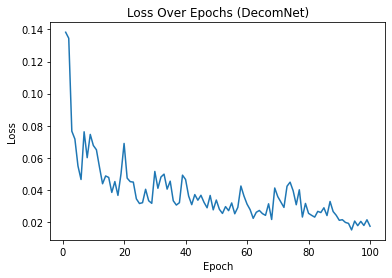

[*] Finish training for phase Decom.
[*] Failed to load model from ./checkpoint\Relight
[*] Not find pretrained model!
[*] Start training for phase Relight, with start epoch 0 start iter 0 : 
Relight Epoch: [ 1] [   1/  31] time: 0.2964, loss: 0.598840
Relight Epoch: [ 1] [   2/  31] time: 0.4962, loss: 3.361188
Relight Epoch: [ 1] [   3/  31] time: 0.6963, loss: 0.284634
Relight Epoch: [ 1] [   4/  31] time: 0.8913, loss: 0.532564
Relight Epoch: [ 1] [   5/  31] time: 1.0883, loss: 0.372775
Relight Epoch: [ 1] [   6/  31] time: 1.2841, loss: 0.257306
Relight Epoch: [ 1] [   7/  31] time: 1.4814, loss: 0.268325
Relight Epoch: [ 1] [   8/  31] time: 1.6799, loss: 0.240769
Relight Epoch: [ 1] [   9/  31] time: 1.8765, loss: 0.310248
Relight Epoch: [ 1] [  10/  31] time: 2.0750, loss: 0.266223
Relight Epoch: [ 1] [  11/  31] time: 2.2723, loss: 0.232469
Relight Epoch: [ 1] [  12/  31] time: 2.4712, loss: 0.245233
Relight Epoch: [ 1] [  13/  31] time: 2.6671, loss: 0.265825
Relight Epoch: 

Relight Epoch: [ 5] [   8/  31] time: 26.1609, loss: 0.145610
Relight Epoch: [ 5] [   9/  31] time: 26.3571, loss: 0.171081
Relight Epoch: [ 5] [  10/  31] time: 26.5533, loss: 0.192202
Relight Epoch: [ 5] [  11/  31] time: 26.7535, loss: 0.272567
Relight Epoch: [ 5] [  12/  31] time: 26.9475, loss: 0.214462
Relight Epoch: [ 5] [  13/  31] time: 27.1422, loss: 0.233375
Relight Epoch: [ 5] [  14/  31] time: 27.3372, loss: 0.237035
Relight Epoch: [ 5] [  15/  31] time: 27.5366, loss: 0.265465
Relight Epoch: [ 5] [  16/  31] time: 27.7317, loss: 0.213469
Relight Epoch: [ 5] [  17/  31] time: 27.9252, loss: 0.144640
Relight Epoch: [ 5] [  18/  31] time: 28.1196, loss: 0.166390
Relight Epoch: [ 5] [  19/  31] time: 28.3161, loss: 0.186826
Relight Epoch: [ 5] [  20/  31] time: 28.5099, loss: 0.146223
Relight Epoch: [ 5] [  21/  31] time: 28.7043, loss: 0.172318
Relight Epoch: [ 5] [  22/  31] time: 28.9026, loss: 0.208289
Relight Epoch: [ 5] [  23/  31] time: 29.0973, loss: 0.134069
Relight 

Relight Epoch: [ 9] [  18/  31] time: 52.5670, loss: 0.155330
Relight Epoch: [ 9] [  19/  31] time: 52.7645, loss: 0.129987
Relight Epoch: [ 9] [  20/  31] time: 52.9632, loss: 0.172579
Relight Epoch: [ 9] [  21/  31] time: 53.1570, loss: 0.150002
Relight Epoch: [ 9] [  22/  31] time: 53.3563, loss: 0.131393
Relight Epoch: [ 9] [  23/  31] time: 53.5471, loss: 0.186060
Relight Epoch: [ 9] [  24/  31] time: 53.7429, loss: 0.151694
Relight Epoch: [ 9] [  25/  31] time: 53.9393, loss: 0.144396
Relight Epoch: [ 9] [  26/  31] time: 54.1359, loss: 0.119430
Relight Epoch: [ 9] [  27/  31] time: 54.3324, loss: 0.156572
Relight Epoch: [ 9] [  28/  31] time: 54.5259, loss: 0.232364
Relight Epoch: [ 9] [  29/  31] time: 54.7195, loss: 0.142233
Relight Epoch: [ 9] [  30/  31] time: 54.9155, loss: 0.160608
Relight Epoch: [ 9] [  31/  31] time: 55.1170, loss: 0.120766
Relight Epoch: [10] [   1/  31] time: 55.3190, loss: 0.196629
Relight Epoch: [10] [   2/  31] time: 55.5205, loss: 0.214066
Relight 

Relight Epoch: [13] [  28/  31] time: 79.0636, loss: 0.156282
Relight Epoch: [13] [  29/  31] time: 79.2659, loss: 0.190341
Relight Epoch: [13] [  30/  31] time: 79.4659, loss: 0.129713
Relight Epoch: [13] [  31/  31] time: 79.6616, loss: 0.155148
Relight Epoch: [14] [   1/  31] time: 79.8573, loss: 0.098552
Relight Epoch: [14] [   2/  31] time: 80.0529, loss: 0.231721
Relight Epoch: [14] [   3/  31] time: 80.2515, loss: 0.196749
Relight Epoch: [14] [   4/  31] time: 80.4547, loss: 0.198591
Relight Epoch: [14] [   5/  31] time: 80.6531, loss: 0.213438
Relight Epoch: [14] [   6/  31] time: 80.8486, loss: 0.203917
Relight Epoch: [14] [   7/  31] time: 81.0440, loss: 0.211379
Relight Epoch: [14] [   8/  31] time: 81.2424, loss: 0.163370
Relight Epoch: [14] [   9/  31] time: 81.4406, loss: 0.168548
Relight Epoch: [14] [  10/  31] time: 81.6369, loss: 0.179515
Relight Epoch: [14] [  11/  31] time: 81.8319, loss: 0.163675
Relight Epoch: [14] [  12/  31] time: 82.0284, loss: 0.190883
Relight 

Relight Epoch: [18] [   5/  31] time: 105.1844, loss: 0.173739
Relight Epoch: [18] [   6/  31] time: 105.3806, loss: 0.186721
Relight Epoch: [18] [   7/  31] time: 105.5786, loss: 0.188684
Relight Epoch: [18] [   8/  31] time: 105.7766, loss: 0.191349
Relight Epoch: [18] [   9/  31] time: 105.9721, loss: 0.180063
Relight Epoch: [18] [  10/  31] time: 106.1708, loss: 0.136992
Relight Epoch: [18] [  11/  31] time: 106.3696, loss: 0.173573
Relight Epoch: [18] [  12/  31] time: 106.5656, loss: 0.126553
Relight Epoch: [18] [  13/  31] time: 106.7599, loss: 0.181101
Relight Epoch: [18] [  14/  31] time: 106.9578, loss: 0.239323
Relight Epoch: [18] [  15/  31] time: 107.1532, loss: 0.215709
Relight Epoch: [18] [  16/  31] time: 107.3532, loss: 0.165959
Relight Epoch: [18] [  17/  31] time: 107.5507, loss: 0.217633
Relight Epoch: [18] [  18/  31] time: 107.7478, loss: 0.197411
Relight Epoch: [18] [  19/  31] time: 107.9451, loss: 0.136856
Relight Epoch: [18] [  20/  31] time: 108.1396, loss: 0

Relight Epoch: [22] [  10/  31] time: 130.7057, loss: 0.194493
Relight Epoch: [22] [  11/  31] time: 130.9005, loss: 0.144344
Relight Epoch: [22] [  12/  31] time: 131.0982, loss: 0.162267
Relight Epoch: [22] [  13/  31] time: 131.2955, loss: 0.162711
Relight Epoch: [22] [  14/  31] time: 131.4927, loss: 0.156709
Relight Epoch: [22] [  15/  31] time: 131.6896, loss: 0.220645
Relight Epoch: [22] [  16/  31] time: 131.8843, loss: 0.222759
Relight Epoch: [22] [  17/  31] time: 132.0801, loss: 0.186439
Relight Epoch: [22] [  18/  31] time: 132.2782, loss: 0.189477
Relight Epoch: [22] [  19/  31] time: 132.4811, loss: 0.241997
Relight Epoch: [22] [  20/  31] time: 132.6756, loss: 0.152232
Relight Epoch: [22] [  21/  31] time: 132.8694, loss: 0.159057
Relight Epoch: [22] [  22/  31] time: 133.0639, loss: 0.150981
Relight Epoch: [22] [  23/  31] time: 133.2558, loss: 0.151116
Relight Epoch: [22] [  24/  31] time: 133.4503, loss: 0.138779
Relight Epoch: [22] [  25/  31] time: 133.6393, loss: 0

Relight Epoch: [26] [  17/  31] time: 156.5952, loss: 0.196170
Relight Epoch: [26] [  18/  31] time: 156.7949, loss: 0.202584
Relight Epoch: [26] [  19/  31] time: 156.9953, loss: 0.188191
Relight Epoch: [26] [  20/  31] time: 157.1940, loss: 0.236096
Relight Epoch: [26] [  21/  31] time: 157.3919, loss: 0.164513
Relight Epoch: [26] [  22/  31] time: 157.5864, loss: 0.163388
Relight Epoch: [26] [  23/  31] time: 157.7820, loss: 0.166284
Relight Epoch: [26] [  24/  31] time: 157.9816, loss: 0.154767
Relight Epoch: [26] [  25/  31] time: 158.1811, loss: 0.142672
Relight Epoch: [26] [  26/  31] time: 158.3769, loss: 0.136064
Relight Epoch: [26] [  27/  31] time: 158.5747, loss: 0.197085
Relight Epoch: [26] [  28/  31] time: 158.7716, loss: 0.127191
Relight Epoch: [26] [  29/  31] time: 158.9696, loss: 0.133498
Relight Epoch: [26] [  30/  31] time: 159.1686, loss: 0.107673
Relight Epoch: [26] [  31/  31] time: 159.3632, loss: 0.139435
Relight Epoch: [27] [   1/  31] time: 159.5594, loss: 0

Relight Epoch: [30] [  25/  31] time: 182.6651, loss: 0.144966
Relight Epoch: [30] [  26/  31] time: 182.8575, loss: 0.123328
Relight Epoch: [30] [  27/  31] time: 183.0607, loss: 0.137582
Relight Epoch: [30] [  28/  31] time: 183.2625, loss: 0.216232
Relight Epoch: [30] [  29/  31] time: 183.4632, loss: 0.116554
Relight Epoch: [30] [  30/  31] time: 183.6617, loss: 0.125671
Relight Epoch: [30] [  31/  31] time: 183.8592, loss: 0.125524
Relight Epoch: [31] [   1/  31] time: 184.0587, loss: 0.118198
Relight Epoch: [31] [   2/  31] time: 184.2552, loss: 0.182756
Relight Epoch: [31] [   3/  31] time: 184.4524, loss: 0.147992
Relight Epoch: [31] [   4/  31] time: 184.6478, loss: 0.145332
Relight Epoch: [31] [   5/  31] time: 184.8396, loss: 0.135631
Relight Epoch: [31] [   6/  31] time: 185.0332, loss: 0.149022
Relight Epoch: [31] [   7/  31] time: 185.2273, loss: 0.162465
Relight Epoch: [31] [   8/  31] time: 185.4198, loss: 0.183266
Relight Epoch: [31] [   9/  31] time: 185.6124, loss: 0

Relight Epoch: [35] [   2/  31] time: 208.7032, loss: 0.117767
Relight Epoch: [35] [   3/  31] time: 208.8946, loss: 0.175977
Relight Epoch: [35] [   4/  31] time: 209.0885, loss: 0.151746
Relight Epoch: [35] [   5/  31] time: 209.2853, loss: 0.139974
Relight Epoch: [35] [   6/  31] time: 209.4788, loss: 0.129601
Relight Epoch: [35] [   7/  31] time: 209.6685, loss: 0.136418
Relight Epoch: [35] [   8/  31] time: 209.8637, loss: 0.179527
Relight Epoch: [35] [   9/  31] time: 210.0644, loss: 0.164804
Relight Epoch: [35] [  10/  31] time: 210.2609, loss: 0.189237
Relight Epoch: [35] [  11/  31] time: 210.4634, loss: 0.185982
Relight Epoch: [35] [  12/  31] time: 210.6605, loss: 0.189455
Relight Epoch: [35] [  13/  31] time: 210.8602, loss: 0.152490
Relight Epoch: [35] [  14/  31] time: 211.0565, loss: 0.136721
Relight Epoch: [35] [  15/  31] time: 211.2512, loss: 0.151338
Relight Epoch: [35] [  16/  31] time: 211.4575, loss: 0.152482
Relight Epoch: [35] [  17/  31] time: 211.6539, loss: 0

Relight Epoch: [39] [  10/  31] time: 234.7816, loss: 0.152449
Relight Epoch: [39] [  11/  31] time: 234.9774, loss: 0.198547
Relight Epoch: [39] [  12/  31] time: 235.1733, loss: 0.177636
Relight Epoch: [39] [  13/  31] time: 235.3685, loss: 0.217275
Relight Epoch: [39] [  14/  31] time: 235.5626, loss: 0.140666
Relight Epoch: [39] [  15/  31] time: 235.7592, loss: 0.141898
Relight Epoch: [39] [  16/  31] time: 235.9637, loss: 0.177575
Relight Epoch: [39] [  17/  31] time: 236.1654, loss: 0.132690
Relight Epoch: [39] [  18/  31] time: 236.3623, loss: 0.166131
Relight Epoch: [39] [  19/  31] time: 236.5608, loss: 0.262470
Relight Epoch: [39] [  20/  31] time: 236.7604, loss: 0.186388
Relight Epoch: [39] [  21/  31] time: 236.9559, loss: 0.203739
Relight Epoch: [39] [  22/  31] time: 237.1508, loss: 0.181419
Relight Epoch: [39] [  23/  31] time: 237.3478, loss: 0.189996
Relight Epoch: [39] [  24/  31] time: 237.5441, loss: 0.191868
Relight Epoch: [39] [  25/  31] time: 237.7377, loss: 0

Relight Epoch: [43] [  15/  31] time: 260.4384, loss: 0.166888
Relight Epoch: [43] [  16/  31] time: 260.6336, loss: 0.128071
Relight Epoch: [43] [  17/  31] time: 260.8284, loss: 0.173641
Relight Epoch: [43] [  18/  31] time: 261.0247, loss: 0.164392
Relight Epoch: [43] [  19/  31] time: 261.2260, loss: 0.160225
Relight Epoch: [43] [  20/  31] time: 261.4255, loss: 0.245181
Relight Epoch: [43] [  21/  31] time: 261.6222, loss: 0.211476
Relight Epoch: [43] [  22/  31] time: 261.8227, loss: 0.150085
Relight Epoch: [43] [  23/  31] time: 262.0157, loss: 0.180443
Relight Epoch: [43] [  24/  31] time: 262.2148, loss: 0.223134
Relight Epoch: [43] [  25/  31] time: 262.4141, loss: 0.161255
Relight Epoch: [43] [  26/  31] time: 262.6115, loss: 0.152912
Relight Epoch: [43] [  27/  31] time: 262.8086, loss: 0.140257
Relight Epoch: [43] [  28/  31] time: 263.0130, loss: 0.118531
Relight Epoch: [43] [  29/  31] time: 263.2145, loss: 0.176336
Relight Epoch: [43] [  30/  31] time: 263.4230, loss: 0

Relight Epoch: [47] [  23/  31] time: 286.6869, loss: 0.182535
Relight Epoch: [47] [  24/  31] time: 286.8860, loss: 0.200845
Relight Epoch: [47] [  25/  31] time: 287.0841, loss: 0.214090
Relight Epoch: [47] [  26/  31] time: 287.2821, loss: 0.178317
Relight Epoch: [47] [  27/  31] time: 287.4806, loss: 0.155264
Relight Epoch: [47] [  28/  31] time: 287.6767, loss: 0.137172
Relight Epoch: [47] [  29/  31] time: 287.8753, loss: 0.153802
Relight Epoch: [47] [  30/  31] time: 288.0708, loss: 0.166276
Relight Epoch: [47] [  31/  31] time: 288.2690, loss: 0.154240
Relight Epoch: [48] [   1/  31] time: 288.4712, loss: 0.186692
Relight Epoch: [48] [   2/  31] time: 288.6712, loss: 0.194405
Relight Epoch: [48] [   3/  31] time: 288.8671, loss: 0.116989
Relight Epoch: [48] [   4/  31] time: 289.0637, loss: 0.111175
Relight Epoch: [48] [   5/  31] time: 289.2643, loss: 0.118955
Relight Epoch: [48] [   6/  31] time: 289.4593, loss: 0.162678
Relight Epoch: [48] [   7/  31] time: 289.6577, loss: 0

Relight Epoch: [51] [  30/  31] time: 312.8666, loss: 0.128669
Relight Epoch: [51] [  31/  31] time: 313.0620, loss: 0.160297
Relight Epoch: [52] [   1/  31] time: 313.2574, loss: 0.157413
Relight Epoch: [52] [   2/  31] time: 313.4586, loss: 0.185782
Relight Epoch: [52] [   3/  31] time: 313.6586, loss: 0.186747
Relight Epoch: [52] [   4/  31] time: 313.8562, loss: 0.112616
Relight Epoch: [52] [   5/  31] time: 314.0521, loss: 0.101427
Relight Epoch: [52] [   6/  31] time: 314.2511, loss: 0.116093
Relight Epoch: [52] [   7/  31] time: 314.4516, loss: 0.167784
Relight Epoch: [52] [   8/  31] time: 314.6520, loss: 0.162768
Relight Epoch: [52] [   9/  31] time: 314.8566, loss: 0.131033
Relight Epoch: [52] [  10/  31] time: 315.0594, loss: 0.140839
Relight Epoch: [52] [  11/  31] time: 315.2637, loss: 0.155118
Relight Epoch: [52] [  12/  31] time: 315.4662, loss: 0.180756
Relight Epoch: [52] [  13/  31] time: 315.6670, loss: 0.147109
Relight Epoch: [52] [  14/  31] time: 315.8673, loss: 0

Relight Epoch: [56] [   7/  31] time: 339.2225, loss: 0.125566
Relight Epoch: [56] [   8/  31] time: 339.4285, loss: 0.153110
Relight Epoch: [56] [   9/  31] time: 339.6207, loss: 0.147765
Relight Epoch: [56] [  10/  31] time: 339.8173, loss: 0.130803
Relight Epoch: [56] [  11/  31] time: 340.0137, loss: 0.149853
Relight Epoch: [56] [  12/  31] time: 340.2112, loss: 0.111191
Relight Epoch: [56] [  13/  31] time: 340.4153, loss: 0.163266
Relight Epoch: [56] [  14/  31] time: 340.6172, loss: 0.162729
Relight Epoch: [56] [  15/  31] time: 340.8154, loss: 0.152341
Relight Epoch: [56] [  16/  31] time: 341.0124, loss: 0.190755
Relight Epoch: [56] [  17/  31] time: 341.2105, loss: 0.172675
Relight Epoch: [56] [  18/  31] time: 341.4110, loss: 0.149658
Relight Epoch: [56] [  19/  31] time: 341.6101, loss: 0.178070
Relight Epoch: [56] [  20/  31] time: 341.8104, loss: 0.192514
Relight Epoch: [56] [  21/  31] time: 342.0059, loss: 0.137874
Relight Epoch: [56] [  22/  31] time: 342.2039, loss: 0

Relight Epoch: [60] [  15/  31] time: 365.6985, loss: 0.162270
Relight Epoch: [60] [  16/  31] time: 365.8991, loss: 0.184636
Relight Epoch: [60] [  17/  31] time: 366.0941, loss: 0.186765
Relight Epoch: [60] [  18/  31] time: 366.2931, loss: 0.176909
Relight Epoch: [60] [  19/  31] time: 366.4907, loss: 0.157033
Relight Epoch: [60] [  20/  31] time: 366.6918, loss: 0.154784
Relight Epoch: [60] [  21/  31] time: 366.8942, loss: 0.173883
Relight Epoch: [60] [  22/  31] time: 367.0926, loss: 0.151019
Relight Epoch: [60] [  23/  31] time: 367.2921, loss: 0.191105
Relight Epoch: [60] [  24/  31] time: 367.4966, loss: 0.190851
Relight Epoch: [60] [  25/  31] time: 367.6910, loss: 0.253861
Relight Epoch: [60] [  26/  31] time: 367.8905, loss: 0.177470
Relight Epoch: [60] [  27/  31] time: 368.0885, loss: 0.188746
Relight Epoch: [60] [  28/  31] time: 368.2860, loss: 0.207564
Relight Epoch: [60] [  29/  31] time: 368.4869, loss: 0.165031
Relight Epoch: [60] [  30/  31] time: 368.6822, loss: 0

Relight Epoch: [64] [  21/  31] time: 391.6696, loss: 0.159318
Relight Epoch: [64] [  22/  31] time: 391.8711, loss: 0.171178
Relight Epoch: [64] [  23/  31] time: 392.0706, loss: 0.139775
Relight Epoch: [64] [  24/  31] time: 392.2721, loss: 0.186865
Relight Epoch: [64] [  25/  31] time: 392.4707, loss: 0.175399
Relight Epoch: [64] [  26/  31] time: 392.6639, loss: 0.204773
Relight Epoch: [64] [  27/  31] time: 392.8580, loss: 0.159592
Relight Epoch: [64] [  28/  31] time: 393.0496, loss: 0.225838
Relight Epoch: [64] [  29/  31] time: 393.2429, loss: 0.210421
Relight Epoch: [64] [  30/  31] time: 393.4423, loss: 0.187843
Relight Epoch: [64] [  31/  31] time: 393.6343, loss: 0.133059
Relight Epoch: [65] [   1/  31] time: 393.8286, loss: 0.139148
Relight Epoch: [65] [   2/  31] time: 394.0272, loss: 0.152378
Relight Epoch: [65] [   3/  31] time: 394.2325, loss: 0.144201
Relight Epoch: [65] [   4/  31] time: 394.4389, loss: 0.150620
Relight Epoch: [65] [   5/  31] time: 394.6377, loss: 0

Relight Epoch: [68] [  29/  31] time: 418.1286, loss: 0.217745
Relight Epoch: [68] [  30/  31] time: 418.3284, loss: 0.217814
Relight Epoch: [68] [  31/  31] time: 418.5290, loss: 0.191416
Relight Epoch: [69] [   1/  31] time: 418.7263, loss: 0.147275
Relight Epoch: [69] [   2/  31] time: 418.9273, loss: 0.130705
Relight Epoch: [69] [   3/  31] time: 419.1280, loss: 0.098016
Relight Epoch: [69] [   4/  31] time: 419.3336, loss: 0.154757
Relight Epoch: [69] [   5/  31] time: 419.5344, loss: 0.129117
Relight Epoch: [69] [   6/  31] time: 419.7337, loss: 0.143418
Relight Epoch: [69] [   7/  31] time: 419.9327, loss: 0.192310
Relight Epoch: [69] [   8/  31] time: 420.1308, loss: 0.127287
Relight Epoch: [69] [   9/  31] time: 420.3323, loss: 0.105855
Relight Epoch: [69] [  10/  31] time: 420.5317, loss: 0.119427
Relight Epoch: [69] [  11/  31] time: 420.7294, loss: 0.159535
Relight Epoch: [69] [  12/  31] time: 420.9284, loss: 0.189959
Relight Epoch: [69] [  13/  31] time: 421.1273, loss: 0

Relight Epoch: [73] [   5/  31] time: 444.4507, loss: 0.150359
Relight Epoch: [73] [   6/  31] time: 444.6527, loss: 0.129117
Relight Epoch: [73] [   7/  31] time: 444.8534, loss: 0.138381
Relight Epoch: [73] [   8/  31] time: 445.0558, loss: 0.146361
Relight Epoch: [73] [   9/  31] time: 445.2559, loss: 0.131511
Relight Epoch: [73] [  10/  31] time: 445.4580, loss: 0.111001
Relight Epoch: [73] [  11/  31] time: 445.6556, loss: 0.129931
Relight Epoch: [73] [  12/  31] time: 445.8564, loss: 0.123912
Relight Epoch: [73] [  13/  31] time: 446.0565, loss: 0.185638
Relight Epoch: [73] [  14/  31] time: 446.2564, loss: 0.108158
Relight Epoch: [73] [  15/  31] time: 446.4655, loss: 0.153799
Relight Epoch: [73] [  16/  31] time: 446.6712, loss: 0.136038
Relight Epoch: [73] [  17/  31] time: 446.8705, loss: 0.160866
Relight Epoch: [73] [  18/  31] time: 447.0689, loss: 0.154321
Relight Epoch: [73] [  19/  31] time: 447.2723, loss: 0.190738
Relight Epoch: [73] [  20/  31] time: 447.4735, loss: 0

Relight Epoch: [77] [  12/  31] time: 470.7373, loss: 0.120348
Relight Epoch: [77] [  13/  31] time: 470.9618, loss: 0.165494
Relight Epoch: [77] [  14/  31] time: 471.1687, loss: 0.191599
Relight Epoch: [77] [  15/  31] time: 471.3892, loss: 0.112263
Relight Epoch: [77] [  16/  31] time: 471.5967, loss: 0.179369
Relight Epoch: [77] [  17/  31] time: 471.8077, loss: 0.130927
Relight Epoch: [77] [  18/  31] time: 472.0221, loss: 0.149667
Relight Epoch: [77] [  19/  31] time: 472.2257, loss: 0.156838
Relight Epoch: [77] [  20/  31] time: 472.4342, loss: 0.156609
Relight Epoch: [77] [  21/  31] time: 472.6400, loss: 0.175777
Relight Epoch: [77] [  22/  31] time: 472.8415, loss: 0.167126
Relight Epoch: [77] [  23/  31] time: 473.0447, loss: 0.175888
Relight Epoch: [77] [  24/  31] time: 473.2426, loss: 0.182398
Relight Epoch: [77] [  25/  31] time: 473.4435, loss: 0.135018
Relight Epoch: [77] [  26/  31] time: 473.6413, loss: 0.163384
Relight Epoch: [77] [  27/  31] time: 473.8442, loss: 0

Relight Epoch: [81] [  18/  31] time: 496.8431, loss: 0.119382
Relight Epoch: [81] [  19/  31] time: 497.0439, loss: 0.158667
Relight Epoch: [81] [  20/  31] time: 497.2412, loss: 0.119884
Relight Epoch: [81] [  21/  31] time: 497.4373, loss: 0.187628
Relight Epoch: [81] [  22/  31] time: 497.6344, loss: 0.183013
Relight Epoch: [81] [  23/  31] time: 497.8319, loss: 0.180732
Relight Epoch: [81] [  24/  31] time: 498.0325, loss: 0.156440
Relight Epoch: [81] [  25/  31] time: 498.2309, loss: 0.164027
Relight Epoch: [81] [  26/  31] time: 498.4294, loss: 0.156531
Relight Epoch: [81] [  27/  31] time: 498.6260, loss: 0.129397
Relight Epoch: [81] [  28/  31] time: 498.8290, loss: 0.169013
Relight Epoch: [81] [  29/  31] time: 499.0285, loss: 0.188329
Relight Epoch: [81] [  30/  31] time: 499.2250, loss: 0.197657
Relight Epoch: [81] [  31/  31] time: 499.4245, loss: 0.216947
Relight Epoch: [82] [   1/  31] time: 499.6201, loss: 0.208971
Relight Epoch: [82] [   2/  31] time: 499.8186, loss: 0

Relight Epoch: [85] [  25/  31] time: 523.0104, loss: 0.191181
Relight Epoch: [85] [  26/  31] time: 523.2009, loss: 0.188155
Relight Epoch: [85] [  27/  31] time: 523.4054, loss: 0.161558
Relight Epoch: [85] [  28/  31] time: 523.6040, loss: 0.160886
Relight Epoch: [85] [  29/  31] time: 523.8053, loss: 0.158286
Relight Epoch: [85] [  30/  31] time: 524.0040, loss: 0.189369
Relight Epoch: [85] [  31/  31] time: 524.2050, loss: 0.237014
Relight Epoch: [86] [   1/  31] time: 524.4081, loss: 0.198737
Relight Epoch: [86] [   2/  31] time: 524.6065, loss: 0.190327
Relight Epoch: [86] [   3/  31] time: 524.8050, loss: 0.170691
Relight Epoch: [86] [   4/  31] time: 525.0035, loss: 0.188571
Relight Epoch: [86] [   5/  31] time: 525.1954, loss: 0.164355
Relight Epoch: [86] [   6/  31] time: 525.3956, loss: 0.156208
Relight Epoch: [86] [   7/  31] time: 525.5975, loss: 0.146007
Relight Epoch: [86] [   8/  31] time: 525.7980, loss: 0.142437
Relight Epoch: [86] [   9/  31] time: 526.0021, loss: 0

Relight Epoch: [90] [   2/  31] time: 549.3415, loss: 0.177389
Relight Epoch: [90] [   3/  31] time: 549.5418, loss: 0.217254
Relight Epoch: [90] [   4/  31] time: 549.7414, loss: 0.165791
Relight Epoch: [90] [   5/  31] time: 549.9441, loss: 0.177835
Relight Epoch: [90] [   6/  31] time: 550.1450, loss: 0.164015
Relight Epoch: [90] [   7/  31] time: 550.3445, loss: 0.140276
Relight Epoch: [90] [   8/  31] time: 550.5428, loss: 0.128434
Relight Epoch: [90] [   9/  31] time: 550.7448, loss: 0.145098
Relight Epoch: [90] [  10/  31] time: 550.9474, loss: 0.138337
Relight Epoch: [90] [  11/  31] time: 551.1586, loss: 0.137770
Relight Epoch: [90] [  12/  31] time: 551.3651, loss: 0.162636
Relight Epoch: [90] [  13/  31] time: 551.5707, loss: 0.116179
Relight Epoch: [90] [  14/  31] time: 551.7762, loss: 0.135018
Relight Epoch: [90] [  15/  31] time: 551.9777, loss: 0.122437
Relight Epoch: [90] [  16/  31] time: 552.1875, loss: 0.136435
Relight Epoch: [90] [  17/  31] time: 552.3860, loss: 0

Relight Epoch: [94] [   9/  31] time: 575.4797, loss: 0.134005
Relight Epoch: [94] [  10/  31] time: 575.6828, loss: 0.133702
Relight Epoch: [94] [  11/  31] time: 575.8802, loss: 0.118887
Relight Epoch: [94] [  12/  31] time: 576.0751, loss: 0.146115
Relight Epoch: [94] [  13/  31] time: 576.2704, loss: 0.185547
Relight Epoch: [94] [  14/  31] time: 576.4692, loss: 0.139377
Relight Epoch: [94] [  15/  31] time: 576.6673, loss: 0.120752
Relight Epoch: [94] [  16/  31] time: 576.8658, loss: 0.127607
Relight Epoch: [94] [  17/  31] time: 577.0719, loss: 0.130722
Relight Epoch: [94] [  18/  31] time: 577.2725, loss: 0.185927
Relight Epoch: [94] [  19/  31] time: 577.4702, loss: 0.140893
Relight Epoch: [94] [  20/  31] time: 577.6644, loss: 0.141197
Relight Epoch: [94] [  21/  31] time: 577.8672, loss: 0.103445
Relight Epoch: [94] [  22/  31] time: 578.0640, loss: 0.149042
Relight Epoch: [94] [  23/  31] time: 578.2661, loss: 0.168279
Relight Epoch: [94] [  24/  31] time: 578.4597, loss: 0

Relight Epoch: [98] [  17/  31] time: 601.9836, loss: 0.119913
Relight Epoch: [98] [  18/  31] time: 602.1879, loss: 0.135943
Relight Epoch: [98] [  19/  31] time: 602.3872, loss: 0.217148
Relight Epoch: [98] [  20/  31] time: 602.5868, loss: 0.142506
Relight Epoch: [98] [  21/  31] time: 602.7841, loss: 0.136985
Relight Epoch: [98] [  22/  31] time: 602.9846, loss: 0.122075
Relight Epoch: [98] [  23/  31] time: 603.1827, loss: 0.188309
Relight Epoch: [98] [  24/  31] time: 603.3857, loss: 0.154490
Relight Epoch: [98] [  25/  31] time: 603.5832, loss: 0.164769
Relight Epoch: [98] [  26/  31] time: 603.7867, loss: 0.208105
Relight Epoch: [98] [  27/  31] time: 603.9877, loss: 0.179650
Relight Epoch: [98] [  28/  31] time: 604.1894, loss: 0.191358
Relight Epoch: [98] [  29/  31] time: 604.3887, loss: 0.164710
Relight Epoch: [98] [  30/  31] time: 604.5885, loss: 0.141617
Relight Epoch: [98] [  31/  31] time: 604.7909, loss: 0.180552
Relight Epoch: [99] [   1/  31] time: 604.9895, loss: 0

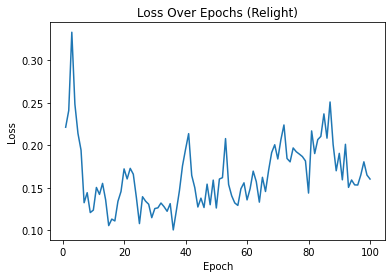

[*] Finish training for phase Relight.


In [9]:
main(args)

## 7.2 - Testing the model

### Arguments detail for testing
    --use_gpu=1 \                           # use gpu or not
    --gpu_idx=0 \
    --gpu_mem=0.5 \                         # gpu memory usage
    --phase=test \
    --test_dir=/path/to/your/test/dir/ \
    --save_dir=/path/to/save/results/ \
    --decom=0                               # save only enhanced results or together with decomposition results

In [8]:
args = argparse.Namespace(use_gpu=1, gpu_idx='0', gpu_mem=0.5, phase='test', test_dir='./test_dataset', save_dir='./test_result', decom=0)

In [9]:
main(args)

[*] GPU

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
[*] Initialize model successfully...
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./model/Decom\RetinexNet-Decom-3100
INFO:tensorflow:Restoring parameters from ./model/Relight\RetinexNet-Relight-3100
[*] Load weights successfully...
[*] Testing...
./test_dataset\Te-gl_0010.jpg
./test_dataset\Te-gl_0011.jpg
./test_dataset\Te-gl_0012.jpg
./test_dataset\Te-gl_0013.jpg
./test_dataset\Te-gl_0014.jpg
./test_dataset\Te-gl_0015.jpg
./test_dataset\Te-gl_0016.jpg
./test_dataset\Te-gl_0017.jpg


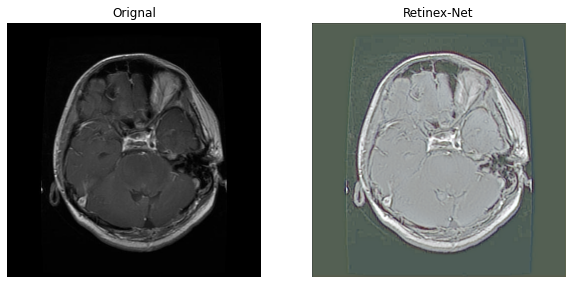

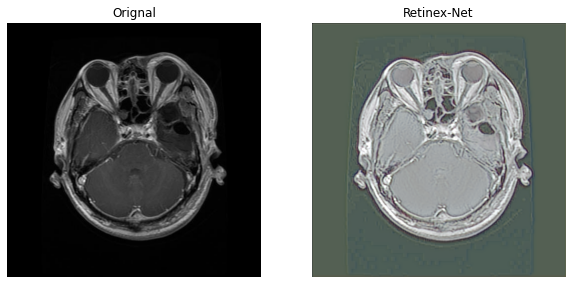

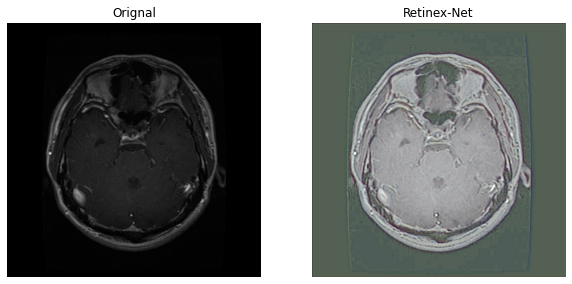

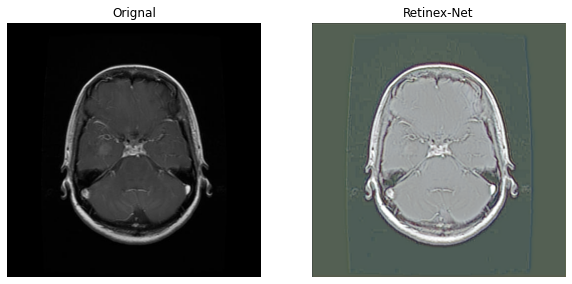

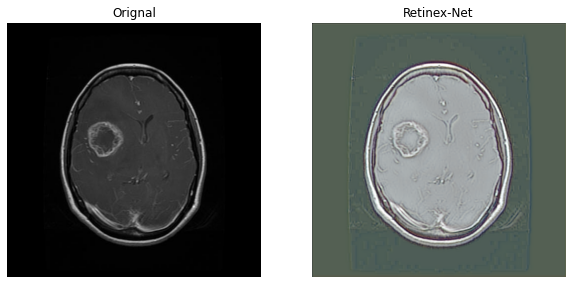

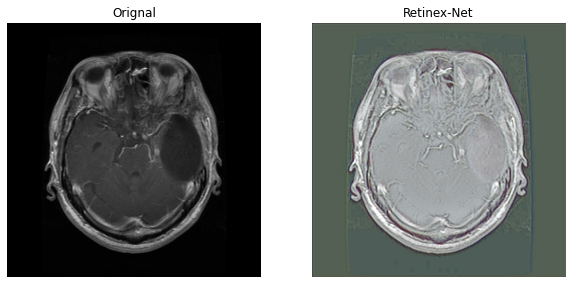

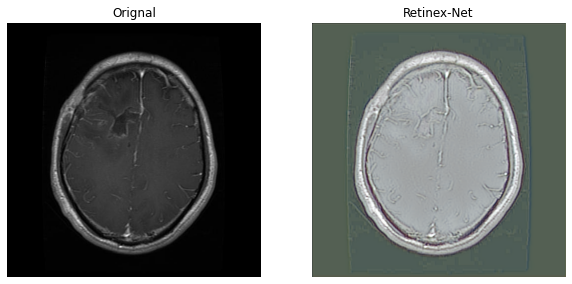

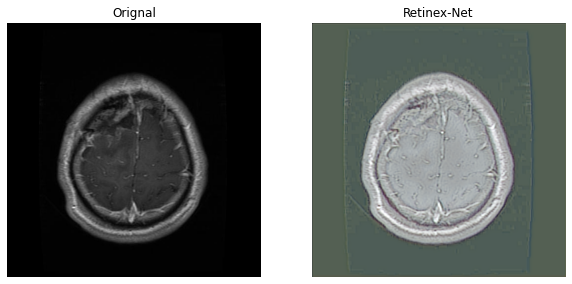

In [10]:
folder1_path = './test_dataset/'
folder2_path = './test_result/'

folder1_images = os.listdir(folder1_path)
folder2_images = os.listdir(folder2_path)

num_images = min(len(folder1_images), len(folder2_images))

for i in range(num_images):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Load and display image from folder 1
    image1_path = os.path.join(folder1_path, folder1_images[i])
    image1 = Image.open(image1_path)
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[0].set_title('Orignal')

    # Load and display image from folder 2
    image2_path = os.path.join(folder2_path, folder2_images[i])
    image2 = Image.open(image2_path)
    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title('Retinex-Net')

    plt.show()